## Imports

In [1]:
import torch
import matplotlib.pyplot as plt
import random
from torchvision import datasets, transforms

In [2]:
from lstm import LSTM
from ddpm import UNET, inference
from grayscott import GrayScott, laplacian
from training import train_lstm, train_ddpm
from analyzer import Analyzer
from constants import *

## Device

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## LSTM Dataset

In [4]:
def create_sine_dataset(samples=100, seq_len=50):
    data = []
    for _ in range(samples):
        # Random frequency and phase to make it robust
        freq = np.random.uniform(0.5, 2.0)
        phase = np.random.uniform(0, 2*np.pi)
        t = np.linspace(0, 10, seq_len)
        
        # Signal = Sine + slight noise
        signal = np.sin(freq * t + phase) + 0.05 * np.random.randn(seq_len)
        data.append(signal)
    
    # Shape: [Batch, Seq_Len, Input_Size=1]
    return torch.FloatTensor(np.array(data)).unsqueeze(2)

In [5]:
samples = create_sine_dataset(100,200)
samples.size()

torch.Size([100, 200, 1])

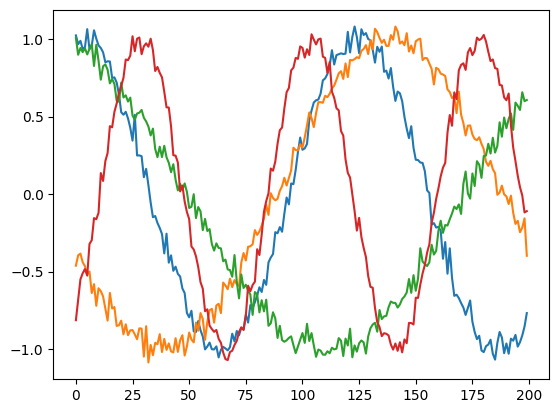

In [6]:
for _ in range(4):
    rand_index = random.randint(0, 100)
    plt.plot(samples[rand_index,:,0])

## LSTM Training

In [50]:
n_samples = 1000
seq_len = 50
n_epochs = 200

In [51]:
lstm_data = create_sine_dataset(samples=n_samples, seq_len=seq_len)
lstm_data = lstm_data.to(device)

lstm_model = LSTM(input_size=1, hidden_size=16).to(device)

--- Training LSTM on cpu ---
Epoch 0: Loss 0.65643
Epoch 10: Loss 0.38569
Epoch 20: Loss 0.17268
Epoch 30: Loss 0.07050
Epoch 40: Loss 0.04413
Epoch 50: Loss 0.03032
Epoch 60: Loss 0.02407
Epoch 70: Loss 0.02072
Epoch 80: Loss 0.01840
Epoch 90: Loss 0.01675
Epoch 100: Loss 0.01544
Epoch 110: Loss 0.01437
Epoch 120: Loss 0.01356
Epoch 130: Loss 0.01290
Epoch 140: Loss 0.01236
Epoch 150: Loss 0.01189
Epoch 160: Loss 0.01147
Epoch 170: Loss 0.01109
Epoch 180: Loss 0.01075
Epoch 190: Loss 0.01043


Text(0.5, 0, 'epoch')

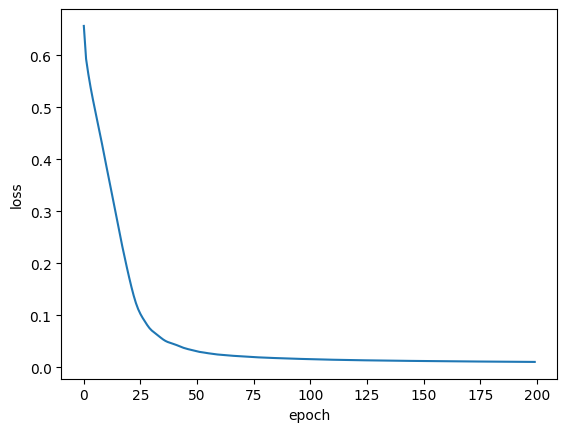

In [52]:
loss_lstm = train_lstm(lstm_model, lstm_data, num_epochs=n_epochs, lr=1e-2, device=device)

plt.plot(loss_lstm)
plt.ylabel("loss")
plt.xlabel("epoch")

Seed shape: torch.Size([50, 1])
Seed values: tensor([[-1.0392],
        [-1.0011],
        [-0.9331],
        [-0.9695],
        [-0.8704]])
Generated shape: torch.Size([100, 1])
Generated values: tensor([[-0.5890],
        [-0.7078],
        [-0.6325],
        [-0.5302],
        [-0.3681]])


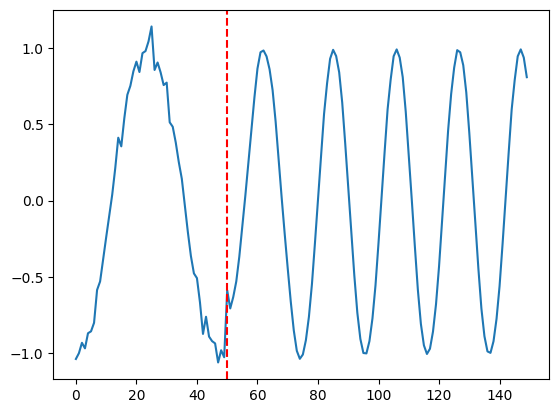

In [53]:
rand_index = random.randint(0, n_samples)
seed_sample = lstm_data[rand_index]

future_steps = 2*seq_len
generated, history_generated = lstm_model.generate_sequence(seed_sample, future_steps=future_steps)

print(f"Seed shape: {seed_sample.shape}")
print(f"Seed values: {seed_sample[:5]}")
print(f"Generated shape: {generated.shape}")
print(f"Generated values: {generated[:5]}")

plt.plot(torch.cat((seed_sample.to("cpu"), generated.to("cpu"))))
plt.axvline(x=seq_len, color='red', linestyle='--')

## LSTM Visualization

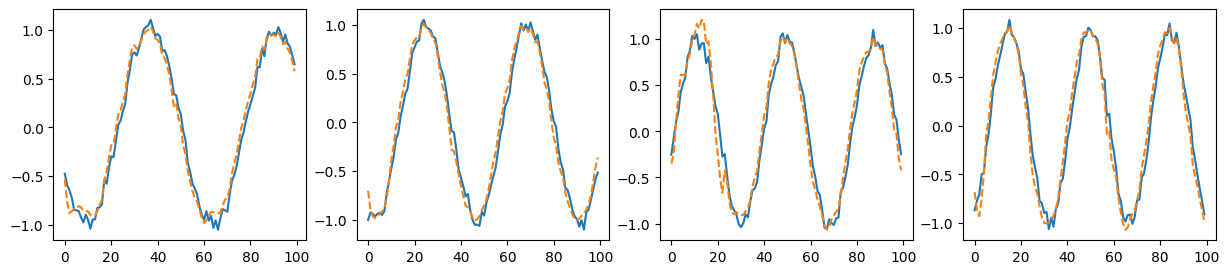

In [11]:
lstm_out, history_lstm = lstm_model(lstm_data)
fig, ax = plt.subplots(1,4, figsize=(15,3))
for i in range(4):
    rand_index = random.randint(0,n_samples)
    ax[i].plot(lstm_data[rand_index,:,0].to("cpu").detach().numpy(), label="true data")
    ax[i].plot(lstm_out[rand_index,:,0].to("cpu").detach().numpy(), linestyle="--", label="lstm output")

plt.show()

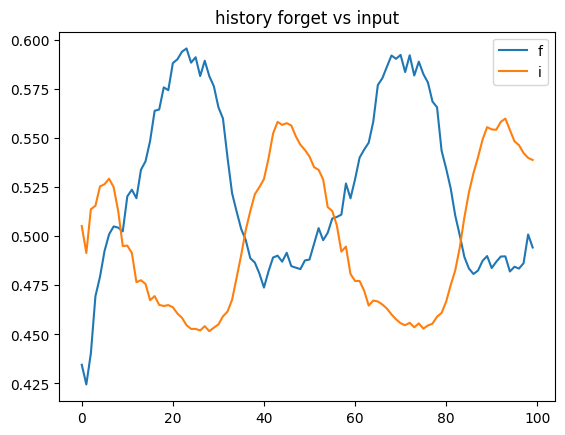

In [12]:
rand_index = random.randint(0,n_samples)
forget = [[t[rand_index, d].item() for t in history_lstm["forget"]] for d in range(16)]
input = [[t[rand_index, d].item() for t in history_lstm["input"]] for d in range(16)]

def mean_forget(forget):
    l = []
    s = 0
    for j in range(seq_len):
        for i in range(16):
            s += forget[i][j]
        l.append(s/16)
        s=0
    return l
forget_mean = mean_forget(forget)
input_mean = mean_forget(input)
plt.plot(forget_mean, label="f")
plt.plot(input_mean, label="i")
plt.title("history forget vs input")
plt.legend()
plt.show()

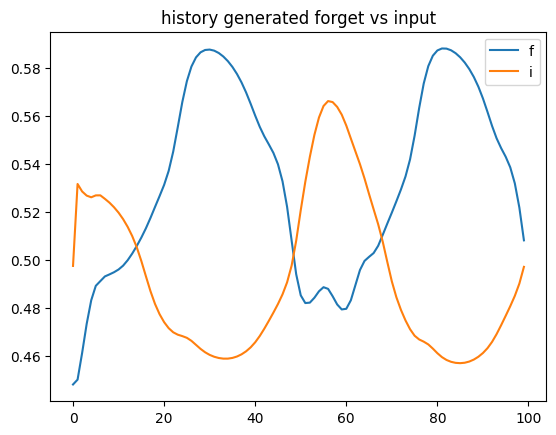

In [13]:
forget = [[t[0, d].item() for t in history_generated["forget"]] for d in range(16)]
input = [[t[0, d].item() for t in history_generated["input"]] for d in range(16)]

def mean_forget(forget):
    l = []
    s = 0
    for j in range(seq_len):
        for i in range(16):
            s += forget[i][j]
        l.append(s/16)
        s=0
    return l
forget_mean = mean_forget(forget)
input_mean = mean_forget(input)
plt.plot(forget_mean, label="f")
plt.plot(input_mean, label="i")
plt.title("history generated forget vs input")
plt.legend()
plt.show()

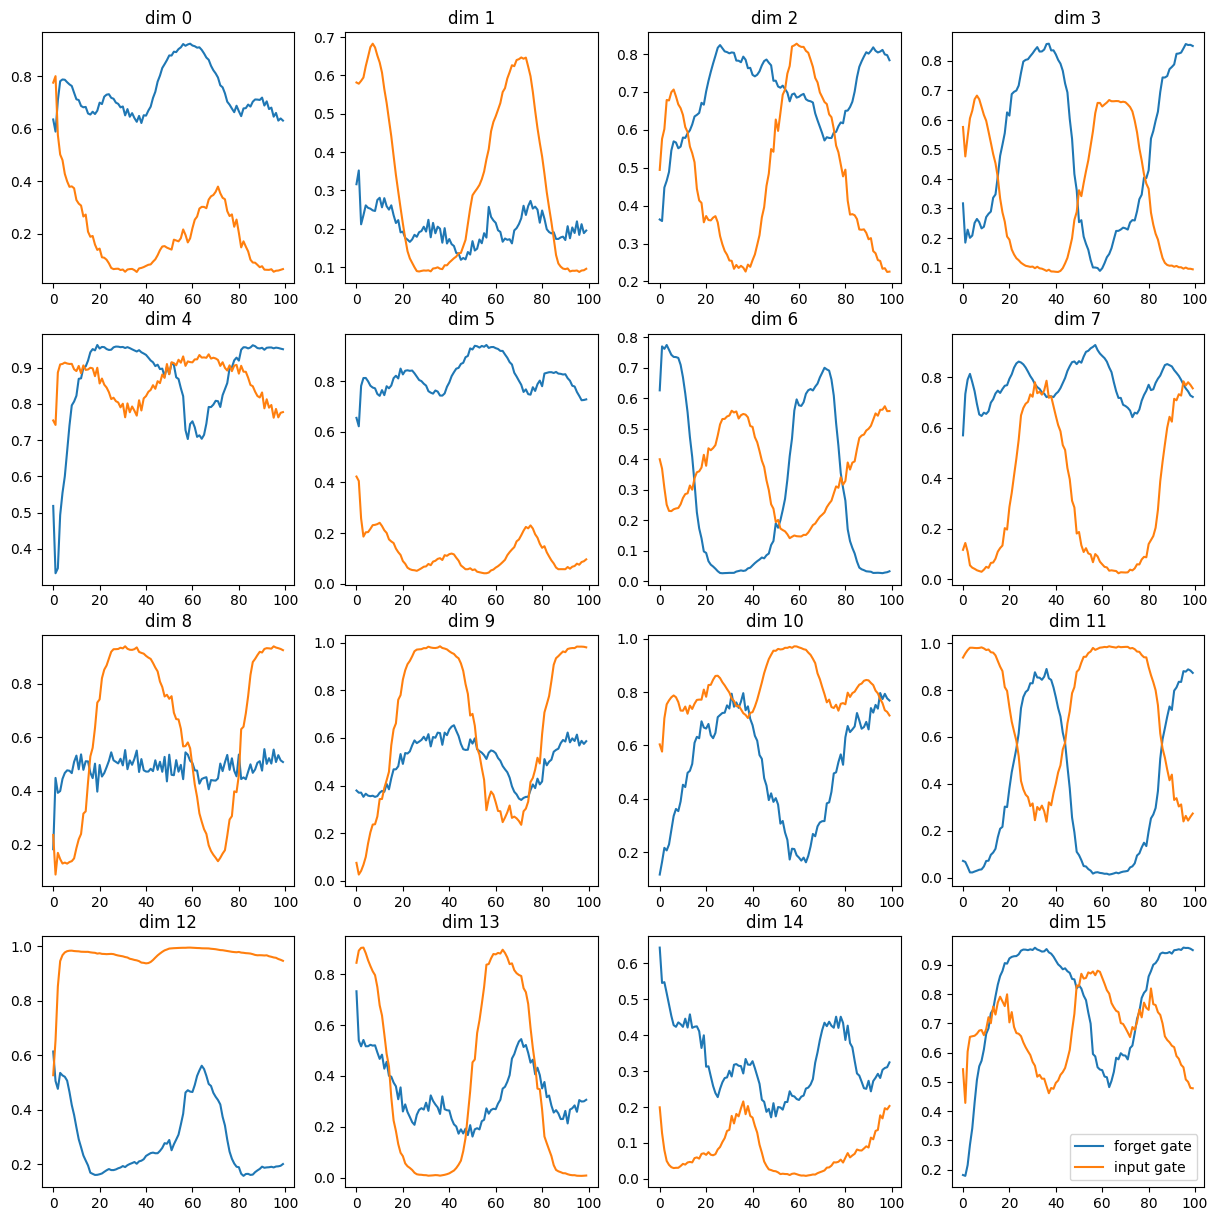

In [14]:
fig, ax = plt.subplots(4,4, figsize=(15,15))

rand_sample = random.randint(0,100)
forget_gate = [[t[rand_sample, d].item() for t in history_lstm["forget"]] for d in range(16)]
input_gate = [[t[rand_sample, d].item() for t in history_lstm["input"]] for d in range(16)]

for i in range(4):
    for j in range(4):
        ax[i,j].plot(forget_gate[4*i+j], label="forget gate")
        ax[i,j].plot(input_gate[4*i+j], label="input gate")
        ax[i,j].set_title(f"dim {4*i+j}")

plt.legend()
plt.show()

## DDPM Training

In [15]:
n_epoch = 5
batch_size = 128
n_T = 1000

In [16]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True,transform=transforms.ToTensor())
ddpm_model = UNET(Channels=[32, 64, 128, 256, 256, 192],          # Much smaller
                  Attentions=[False, True, False, False, True, False], # Keep attention sparse
                  Upscales=[False, False, False, True, True, True],
                  num_groups=8  # Reduce groups since channels are smaller
              ).to(device)

--- Training DDPM on cpu ---


Epoch 1/5: 100%|██████████| 1/1 [00:11<00:00, 11.54s/it]


Epoch 1 | Loss 1.01695


Epoch 2/5: 100%|██████████| 1/1 [00:09<00:00,  9.66s/it]


Epoch 2 | Loss 0.99955


Epoch 3/5: 100%|██████████| 1/1 [00:08<00:00,  8.05s/it]


Epoch 3 | Loss 0.99746


Epoch 4/5: 100%|██████████| 1/1 [00:07<00:00,  7.97s/it]


Epoch 4 | Loss 0.98841


Epoch 5/5: 100%|██████████| 1/1 [00:09<00:00,  9.84s/it]


Epoch 5 | Loss 0.99059


Text(0.5, 0, 'epoch')

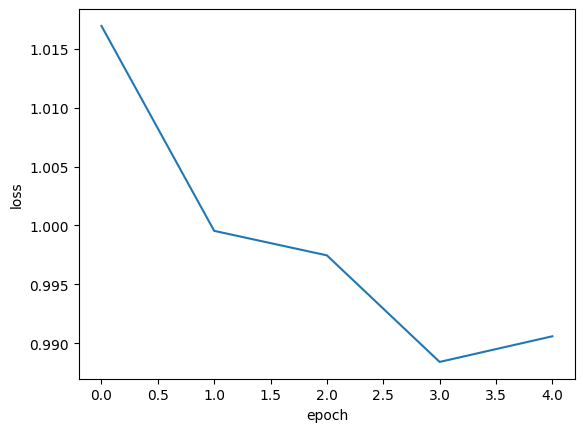

In [17]:
losses = train_ddpm(model=ddpm_model, data=train_dataset, batch_size=batch_size,num_time_steps=n_T, lr=2e-5, num_epochs=n_epoch, device=device, dataset_size=128)

plt.plot(losses)
plt.ylabel("loss")
plt.xlabel("epoch")

Starting inference on cpu with 1000 steps...


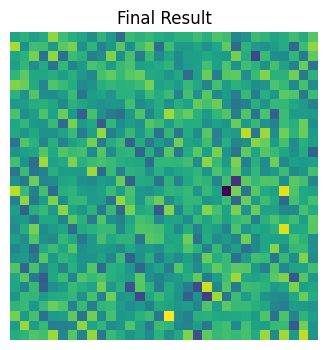

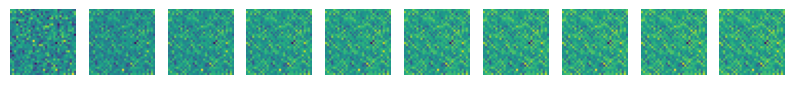

In [18]:
history_ddpm = inference(ddpm_model=ddpm_model, checkpoint_path="checkpoints/ddpm_checkpoint", num_time_steps=n_T)

In [19]:
history_ddpm["drift"][0].shape

(1, 1, 32, 32)

## Comparison

In [20]:
def run_rd_exp(model):
    print("=== RD Analysis ===")

    V_view = model.V[1:-1, 1:-1]
    U_view = model.U[1:-1, 1:-1]
    
    # Diffusion Force Magnitude
    lap_V = laplacian(model.V, model.dx)
    force_diff = np.abs(model.D_v * lap_V)
    
    # Reaction Force Magnitude
    uv2 = U_view * V_view**2
    reaction_V = uv2 - (model.F + model.k) * V_view
    force_react = np.abs(reaction_V)
    
    # Metrics: Mean magnitude per cell
    m_diff = np.mean(force_diff)
    m_react = np.mean(force_react)
    
    print(f"RD Diffusion Force: {m_diff}")
    print(f"RD Reaction Force:  {m_react}")
    
    return m_diff, m_react, force_diff, force_react

def run_lstm_exp(history):
    print("=== LSTM Analysis ===")

    diff_forces, react_forces = [], []

    for t in range(len(history["input"])):
        i_t = history["input"][t]
        f_t = history["forget"][t]
        C_tilde = history["cell_update"][t]
        C_t = history["cell"][t]
                
        # Reaction (Restoring Force): 
        # The force pushing the state to the new value (oscillation update)
        # Magnitude of new information injected: |i_t * C_tilde|
        f_react = torch.mean(torch.abs(i_t * C_tilde)).item()
        
        # Diffusion (Decay/Stabilization):
        # The force eroding the previous state (forgetting)
        # Magnitude of information removed: |(1 - f_t) * C_prev|
        f_diff = torch.mean(torch.abs((f_t) * C_t)).item()
        
        diff_forces.append(f_diff)
        react_forces.append(f_react)
            
    m_diff = np.mean(diff_forces)
    m_react = np.mean(react_forces)

    print(f"LSTM Diffusion Force: {m_diff}")
    print(f"LSTM Reaction Force:  {m_react}")
    
    return m_diff, m_react, diff_forces, react_forces

def run_ddpm_exp(history):
    print("=== DDPM Analysis ===")
    drift_forces = []
    noise_forces = []

    for t in range(len(history_ddpm["time"])):
        drift_vector = torch.tensor(history["drift"][t])
        diffusion_term = torch.tensor(history["diffusion"][t])

        f_react = torch.mean(torch.abs(drift_vector)).item()
        drift_forces.append(f_react)

        f_diff = torch.mean(torch.abs(diffusion_term)).item()
        noise_forces.append(f_diff)

    m_diff = np.mean(noise_forces)
    m_react = np.mean(drift_forces)
    
    print(f"DDPM Noise Force (Diff):  {m_diff}")
    print(f"DDPM Drift Force (React): {m_react}")
    
    return m_diff, m_react, noise_forces, drift_forces


In [21]:
F_list = np.linspace(0.029, 0.0545, 10) # spots to strides
k = 0.062
D_u = 1e-5
D_v = 0.5e-5
T_max = 10000
gs = GrayScott(F=F_list[9], k=k,D_u=D_u, D_v=D_v, N=256)
gs.forward(0,T_max, frame=True, data=False)
rd_diff, rd_react, rd_diff_list, rd_react_list = run_rd_exp(gs)

F=0.054, k=0.062: 100%|███████████████████████████████████████▉| 8190/8192 [00:15<00:00, 517.75it/s]


=== RD Analysis ===
RD Diffusion Force: 0.0024677757554122867
RD Reaction Force:  0.002465897704290994


=== LSTM Analysis ===
LSTM Diffusion Force: 0.6208829051918454
LSTM Reaction Force:  0.3494470263972427


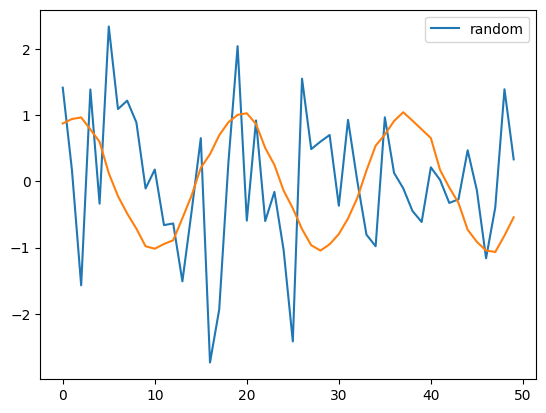

In [58]:
rand_index = random.randint(0, n_samples)
seed_sample = lstm_data[rand_index]
seed_sample_random = torch.randn(seq_len, 1)
generated, history_lstm_gen = lstm_model.generate_sequence(seed_sample, future_steps=future_steps)
lstm_diff, lstm_react, lstm_diff_list, lstm_react_list = run_lstm_exp(history_lstm_gen)

plt.plot(seed_sample_random, label="random")
plt.plot(seed_sample)
plt.legend()
plt.show()

Starting inference on cpu with 1000 steps...


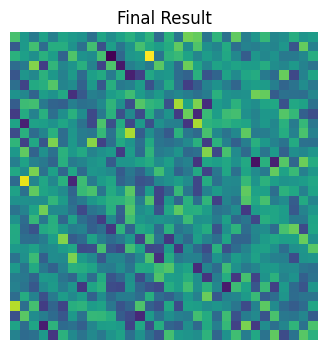

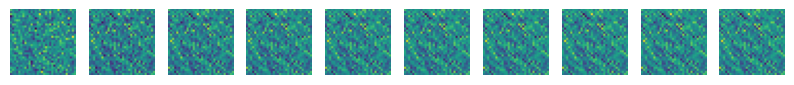

=== DDPM Analysis ===
DDPM Noise Force (Diff):  0.07547997253574432
DDPM Drift Force (React): 0.2094902725443244


In [55]:
history_ddpm = inference(ddpm_model=ddpm_model, checkpoint_path="checkpoints/ddpm_checkpoint", num_time_steps=n_T)
ddpm_diff, ddpm_react, ddpm_diff_list, ddpm_react_list = run_ddpm_exp(history_ddpm)

In [59]:
# Calculate Ratios
rd_ratio = rd_react / (rd_diff if rd_diff != 0 else rd_diff + 1e-10)
lstm_ratio = lstm_react / (lstm_diff if lstm_diff != 0 else lstm_diff + 1e-10)
ddpm_ratio = ddpm_react / (ddpm_diff if ddpm_diff != 0 else ddpm_diff + 1e-10)

print(f"{'Model':<20} | {'M_diff (Decay)':<18} | {'M_react (Growth)':<18} | {'Ratio (R)':<15}")
print("-" * 80)
print(f"{'Gray-Scott (RD)':<20} | {rd_diff:<18.8f} | {rd_react:<18.8f} | {rd_ratio:<15.8f}")
print(f"{'LSTM':<20} | {lstm_diff:<18.8f} | {lstm_react:<18.8f} | {lstm_ratio:<15.8f}")
print(f"{'DDPM':<20} | {ddpm_diff:<18.8f} | {ddpm_react:<18.8f} | {ddpm_ratio:<15.8f}")

Model                | M_diff (Decay)     | M_react (Growth)   | Ratio (R)      
--------------------------------------------------------------------------------
Gray-Scott (RD)      | 0.00246778         | 0.00246590         | 0.99923897     
LSTM                 | 0.62088291         | 0.34944703         | 0.56282275     
DDPM                 | 0.07547997         | 0.20949027         | 2.77544182     


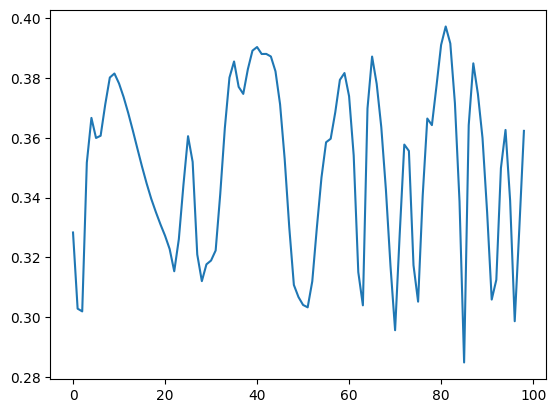

In [61]:
plt.plot(lstm_react_list)

/tmp/ipykernel_37117/2349645261.py:33: RuntimeWarning: overflow encountered in square
  uv2 = self.U[1:-1, 1:-1] * self.V[1:-1, 1:-1]**2
/tmp/ipykernel_37117/2349645261.py:37: RuntimeWarning: invalid value encountered in add
  self.U[1:-1, 1:-1] += self.dt * (self.D_u * lap_u - uv2 + self.F * (1 - self.U[1:-1, 1:-1]))
/tmp/ipykernel_37117/2349645261.py:38: RuntimeWarning: invalid value encountered in add
  self.V[1:-1, 1:-1] += self.dt * (self.D_v * laplacian(self.V, self.dx) + uv2 - (self.F + self.k) * self.V[1:-1, 1:-1])
/tmp/ipykernel_37117/2349645261.py:114: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:345.)
  r_lstm = np.mean(lstm_data['react']) / np.mea

IndexError: too many indices for tensor of dimension 3

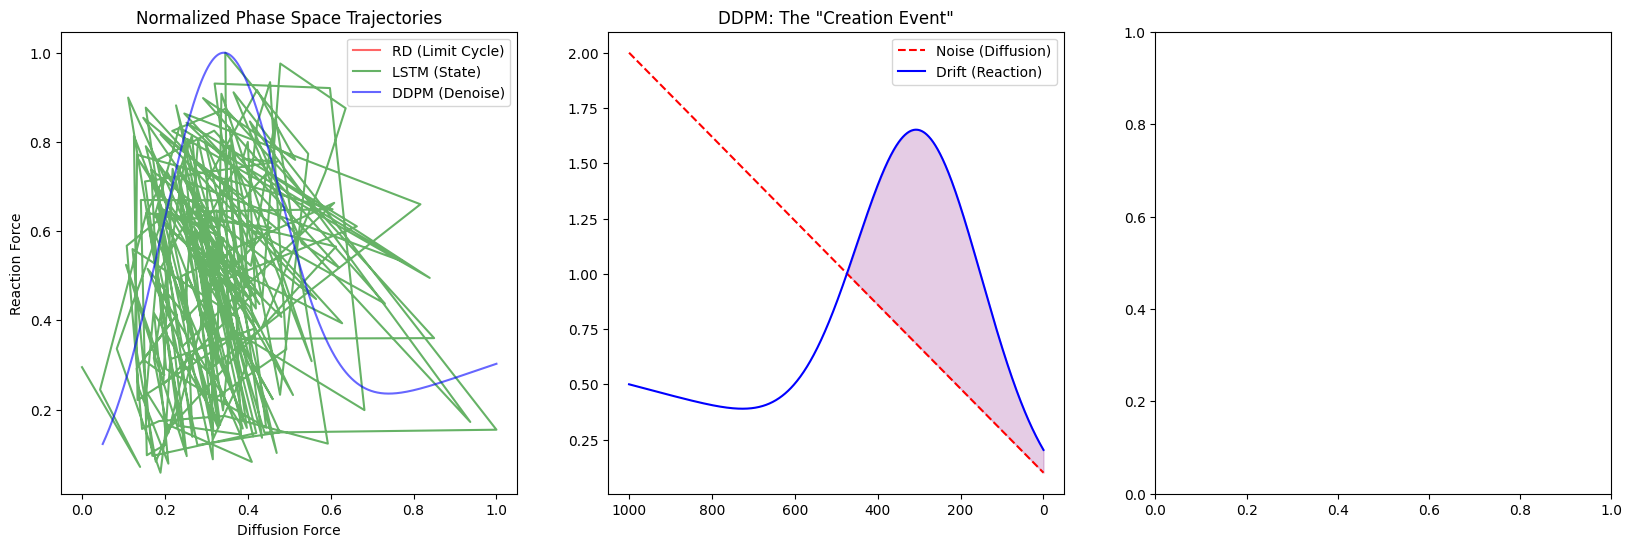

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. Comparison Simulation (NumPy Implementation)
# ==========================================

def sigmoid(x): return 1 / (1 + np.exp(-x))
def tanh(x): return np.tanh(x)
def laplacian(u, h):
    return (u[2:, 1:-1] + u[1:-1, 2:] + u[:-2, 1:-1] + u[1:-1, :-2] - 4 * u[1:-1, 1:-1]) / h**2

# --- A. Gray-Scott (RD) ---
class GrayScott_NP:
    def __init__(self, F=0.0545, k=0.062, N=64): # Spot pattern parameters
        self.F, self.k = F, k
        self.D_u, self.D_v = 1e-5, 0.5e-5
        self.dx = 2.0 / N
        self.dt = self.dx**2 / (5 * 1e-5)
        self.U = np.ones((N+2, N+2))
        self.V = np.zeros((N+2, N+2))
        # Initial perturbation
        mid = N // 2
        self.U[mid-10:mid+10, mid-10:mid+10] = 0.50
        self.V[mid-10:mid+10, mid-10:mid+10] = 0.25

    def step_forces(self):
        # Calculate Laplacian (Diffusion Force)
        lap_u = laplacian(self.U, self.dx)
        diff_force = np.mean(np.abs(self.D_u * lap_u))
        
        # Calculate Reaction Force
        uv2 = self.U[1:-1, 1:-1] * self.V[1:-1, 1:-1]**2
        react_force = np.mean(np.abs(-uv2 + self.F * (1 - self.U[1:-1, 1:-1])))
        
        # Update State
        self.U[1:-1, 1:-1] += self.dt * (self.D_u * lap_u - uv2 + self.F * (1 - self.U[1:-1, 1:-1]))
        self.V[1:-1, 1:-1] += self.dt * (self.D_v * laplacian(self.V, self.dx) + uv2 - (self.F + self.k) * self.V[1:-1, 1:-1])
        return diff_force, react_force

# --- B. LSTM (NumPy) ---
class LSTM_NP:
    def __init__(self, hidden_size=32):
        self.W_f = np.random.randn(hidden_size, 1)
        self.W_i = np.random.randn(hidden_size, 1)
        self.W_C = np.random.randn(hidden_size, 1)
        self.h = np.zeros((hidden_size, 1))
        self.c = np.zeros((hidden_size, 1))

    def step_forces(self, x):
        # Gates
        f_t = sigmoid(self.W_f * x + 0.5 * self.h) # Simplified weight for demo
        i_t = sigmoid(self.W_i * x + 0.5 * self.h)
        C_tilde = tanh(self.W_C * x + 0.5 * self.h)
        
        # Forces
        react_force = np.mean(np.abs(i_t * C_tilde)) # Information Injection
        diff_force = np.mean(np.abs((1 - f_t) * self.c)) # Information Decay
        
        # Update
        self.c = f_t * self.c + i_t * C_tilde
        self.h = tanh(self.c)
        return diff_force, react_force

# ==========================================
# 2. Run Experiments & Plot
# ==========================================
rd_data_ = {'diff': [], 'react': []}
lstm_data_ = {'diff': [], 'react': []}

# Run RD
gs = GrayScott_NP()
for _ in range(1000):
    d, r = gs.step_forces()
    rd_data_['diff'].append(d)
    rd_data_['react'].append(r)

# Run LSTM
lstm = LSTM_NP()
inputs = np.random.randn(200)
for x in inputs:
    d, r = lstm.step_forces(x)
    lstm_data_['diff'].append(d)
    lstm_data_['react'].append(r)

# Simulate DDPM Crossover (Theoretical)
t = np.linspace(1000, 0, 1000)
ddpm_diff = np.linspace(2.0, 0.1, 1000) # Noise decays
ddpm_react = 0.5 * t/1000 + 1.5 * np.exp(-((t - 300)**2)/(2*150**2)) # Drift peaks

# --- Plotting ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Phase Space
def norm(x): return np.array(x) / np.max(x)
axes[0].plot(norm(rd_data_['diff']), norm(rd_data_['react']), label='RD (Limit Cycle)', c='r', alpha=0.6)
axes[0].plot(norm(lstm_data_['diff']), norm(lstm_data_['react']), label='LSTM (State)', c='g', alpha=0.6)
axes[0].plot(norm(ddpm_diff), norm(ddpm_react), label='DDPM (Denoise)', c='b', alpha=0.6)
axes[0].set_title('Normalized Phase Space Trajectories')
axes[0].set_xlabel('Diffusion Force')
axes[0].set_ylabel('Reaction Force')
axes[0].legend()

# Plot 2: DDPM Crossover
axes[1].plot(t, ddpm_diff, 'r--', label='Noise (Diffusion)')
axes[1].plot(t, ddpm_react, 'b-', label='Drift (Reaction)')
axes[1].fill_between(t, ddpm_diff, ddpm_react, where=(ddpm_react > ddpm_diff), color='purple', alpha=0.2)
axes[1].invert_xaxis()
axes[1].set_title('DDPM: The "Creation Event"')
axes[1].legend()

# Plot 3: Ratios
r_rd = np.mean(rd_data_['react']) / np.mean(rd_data_['diff'])
r_lstm = np.mean(lstm_data['react']) / np.mean(lstm_data['diff'])
r_ddpm = np.mean(ddpm_react) / np.mean(ddpm_diff)
axes[2].bar(['RD', 'LSTM', 'DDPM'], [r_rd, r_lstm, r_ddpm], color=['r', 'g', 'b'], alpha=0.7)
axes[2].set_title('Dynamic Balance Ratio (R)')

plt.tight_layout()
plt.show()

In [ ]:
# 1. Get Gray Scott Data
# gs is your GrayScott instance
# gs_history should be a list of frames you saved during the loop
gs = GrayScott(F=F_DEFAULT, k=k_DEFAULT, D_u=Du_DEFAULT, D_v=Dv_DEFAULT, x0=x0, x1=x1, N=N)
_, V_final, V_history, _, _ = gs.forward(0, 5000, frame=False, data=False)
gs_final = V_final[1:-1, 1:-1]
gs_history = np.array(V_history) # Shape: [Time, H, W]

# 2. Get LSTM Data
# output is the predicted sequence [Batch, Seq, 1]
lstm_output, _ = lstm.forward(lstm_data)
lstm_final = lstm_output[0, :, 0].to("cpy").detach().numpy()
lstm_history = lstm_output[0, :, :].to("cpu").detach().numpy() # Treat sequence as history

# 3. Get DDPM Data
# final_img is [1, 28, 28]
# history is list of arrays [Time, 1, 28, 28]
ddpm_final_img, ddpm_history_list = ddpm_model.sample(1,)
ddpm_final = ddpm_final_img.squeeze().cpu().numpy()
ddpm_history = np.array([x.squeeze() for x in ddpm_history_list])

# 4. Run Comparison
analyzer = Analyzer()
analyzer.compare_models(gs_final, gs_history, 
                        lstm_final, lstm_history, 
                        ddpm_final, ddpm_history)

F=0.054, k=0.062: 100%|███████████████████████████████████████▉| 8190/8192 [00:12<00:00, 655.75it/s]


AttributeError: 'LSTM_NP' object has no attribute 'forward'